## Nickhil Tekwani || CS6220 || Hw 2B

### Problem 5: DBSCAN on toy-neighborhood data

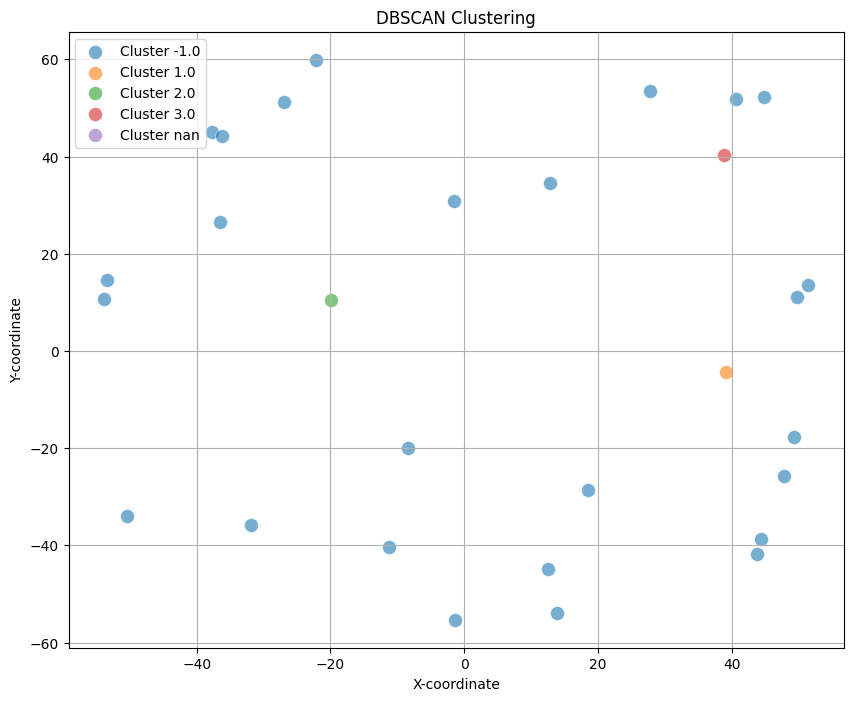

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('dbscan.csv')

# Convert necessary columns to appropriate data types
data['x'] = data['x'].astype(float)
data['y'] = data['y'].astype(float)
data['num_neighbors'] = data['num_neighbors'].astype(int)
data['neighbors'] = data['neighbors'].str.split(',').apply(lambda x: [int(i) for i in x])

# Define DBSCAN algorithm
def dbscan(data, epsilon=7.5, min_pts=3):
    NOISE = -1
    cluster_label = 0
    
    # Initially, all points are not visited
    visited = np.zeros(data.shape[0], dtype=bool)
    
    for index, point in data.iterrows():
        if visited[index]:
            continue

        visited[index] = True

        # Get neighbors
        neighbors = point['neighbors']

        if len(neighbors) < min_pts:
            data.at[index, 'cluster'] = NOISE
        else:
            cluster_label += 1
            expand_cluster(data, point, neighbors, cluster_label, epsilon, min_pts, visited)

def expand_cluster(data, point, neighbors, cluster_label, epsilon, min_pts, visited):
    data.at[point.name, 'cluster'] = cluster_label

    i = 0
    while i < len(neighbors):
        neighbor_pt_index = neighbors[i]
        if not visited[neighbor_pt_index]:
            visited[neighbor_pt_index] = True

            new_neighbors = data.iloc[neighbor_pt_index]['neighbors']
            if len(new_neighbors) >= min_pts:
                neighbors.extend(new_neighbors)

        # Assign the cluster label if not assigned already
        if data.iloc[neighbor_pt_index]['cluster'] <= 0:
            data.at[neighbor_pt_index, 'cluster'] = cluster_label

        i += 1

# Run DBSCAN
dbscan(data)

# Visualize the results
colors = ['g', 'r', 'b', 'y', 'c', 'm']

plt.figure(figsize=(10, 8))
clusters = np.unique(data['cluster'])

for cluster in clusters:
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}', alpha=0.6, edgecolors='w', linewidth=0.5, s=100)

plt.title('DBSCAN Clustering')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()


### PROBLEM 6: DBSCAN on toy raw data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs

# Create the datasets
data_moons, _ = make_moons(n_samples=500, noise=0.05)
data_circles, _ = make_circles(n_samples=500, factor=0.5, noise=0.05)
data_blobs, _ = make_blobs(n_samples=500, random_state=5, n_features=2, centers=3)


In [3]:
from sklearn.neighbors import NearestNeighbors

def dbscan(data, eps, min_samples):
    labels = np.zeros(len(data), dtype=int) - 1
    C = 0
    
    for i in range(len(data)):
        if labels[i] != -1:
            continue
            
        neighbors = retrieve_neighbors(i, data, eps)
        
        if len(neighbors) < min_samples:
            labels[i] = -1  # Noise
            continue
        
        C += 1  # New cluster
        grow_cluster(i, neighbors, C, eps, min_samples, data, labels)
    
    return labels

def retrieve_neighbors(p, data, eps):
    distances = np.linalg.norm(data - data[p], axis=1)
    return np.where(distances < eps)[0]

def grow_cluster(p, neighbors, C, eps, min_samples, data, labels):
    labels[p] = C
    i = 0
    while i < len(neighbors):
        n = neighbors[i]
        
        if labels[n] == -1:  # Noise
            labels[n] = C
        
        elif labels[n] == 0:  # Not yet visited
            labels[n] = C
            new_neighbors = retrieve_neighbors(n, data, eps)
            
            if len(new_neighbors) >= min_samples:
                neighbors = np.append(neighbors, new_neighbors)
        
        i += 1


In [4]:
eps = 0.3
min_samples = 5

labels_moons = dbscan(data_moons, eps, min_samples)
labels_circles = dbscan(data_circles, eps, min_samples)
labels_blobs = dbscan(data_blobs, eps, min_samples)


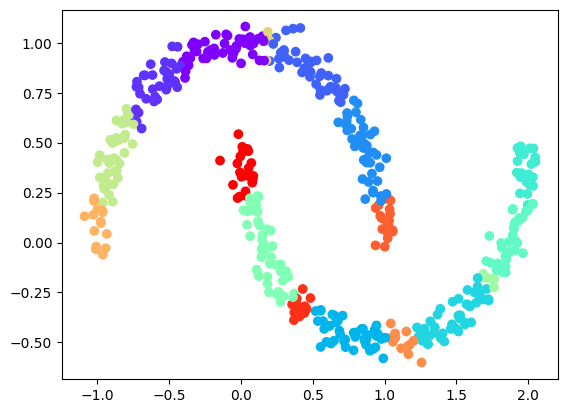

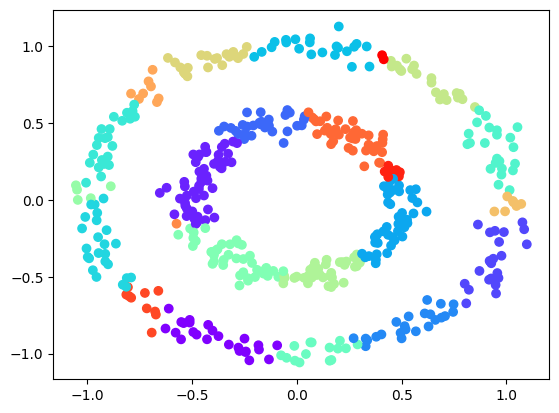

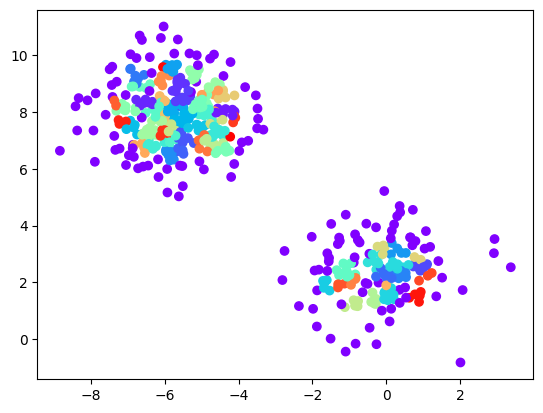

In [5]:
def plot_clusters(data, labels):
    plt.scatter(data[:,0], data[:,1], c=labels, cmap='rainbow')
    plt.show()

plot_clusters(data_moons, labels_moons)
plot_clusters(data_circles, labels_circles)
plot_clusters(data_blobs, labels_blobs)


### PROBLEM 7: DBSCAN on real data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.datasets import fetch_20newsgroups, fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# DBSCAN Implementation (same as before)
# def dbscan(data, eps, min_samples):
#     print('null')

# Silhouette Score Evaluation
def evaluate_silhouette(data, labels):
    score = silhouette_score(data, labels)
    print(f"Silhouette Score: {score}")



In [7]:
# Load data
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_ng = vectorizer.fit_transform(newsgroups.data).toarray()

# Dimensionality Reduction using PCA
X_ng_pca = PCA(n_components=50).fit_transform(X_ng)

# Run DBSCAN
labels_ng = dbscan(X_ng_pca, eps=0.5, min_samples=5)
evaluate_silhouette(X_ng_pca, labels_ng)


Silhouette Score: 0.0004961633692568019


In [ ]:
# Load data
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, cache=True)
X_fashion = fashion_mnist.data.values / 255.0  # Normalize

# Run DBSCAN
labels_fashion = dbscan(X_fashion, eps=0.5, min_samples=5)
evaluate_silhouette(X_fashion, labels_fashion)


In [ ]:
def plot_k_distance_graph(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    plt.show()

# 20NG Plot
plot_k_distance_graph(X_ng_pca)


### Why/When DBSCAN Works:
- Excels with clusters of similar density
- Effectively handles noise and outliers
- No need to specify the number of clusters
- Can detect clusters of arbitrary shapes

### Why/When DBSCAN Doesn't Work:
- Struggles with clusters of varying densities
- Ambiguity with border points
- Sensitive to choice of `eps` and `MinPts` parameters
- Challenges with high-dimensional data
- Potential scalability issues with large datasets
- Interpretation of parameters can be unclear

### Speculation for Datasets:
**20NG**:
  - High dimensionality of text data can be a challenge
  - Might group similar topics together
  
**FASHION**:
  - Might group similar-looking clothing items together
  - High dimensional (784D for 28x28 images)
  
**HouseHold**:
  - Overlapping consumption patterns can merge clusters
  - Important anomalies might be labeled as noise


### PROBLEM 8: Hierarchical Clustering

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

moons = pd.read_csv('moons.csv')
sample_data = moons.sample(n=5000)  # taking a sample of 5000 data points

# The 'linkage' function computes the hierarchical clustering
# 'ward' is one of the methods to compute distances between clusters
Z = linkage(sample_data, method='average')  # you can replace 'average' with 'single' for single_dist

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

# Cut dendrogram
# For K=2 clusters
labels_2 = fcluster(Z, t=2, criterion='maxclust')
# For K=5 clusters
labels_5 = fcluster(Z, t=5, criterion='maxclust')
# For K=10 clusters
labels_10 = fcluster(Z, t=10, criterion='maxclust')

# Evaluate Clusters
score_2 = silhouette_score(sample_data, labels_2)
score_5 = silhouette_score(sample_data, labels_5)
score_10 = silhouette_score(sample_data, labels_10)

print(f'Silhouette Score for K=2: {score_2}')
print(f'Silhouette Score for K=5: {score_5}')
print(f'Silhouette Score for K=10: {score_10}')
